In [197]:
!pip install seaborn

In [199]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
from sklearn.tree import _tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [278]:
# Load UMAP data
#data = pd.read_csv("Umap_data_2D_deepfool_7000_final.csv")
#data = pd.read_csv("Umap_data_3D_deepfoo1_7000_final.csv")
#data = pd.read_csv("Umap_data_5D_deepfool_7000_final.csv")
data = pd.read_csv("Umap_data_10D_deepfool_7000_final.csv")


X = data.drop(columns = "attack")
output_label = "attack"
y = data[output_label]

# split UMAP loaded dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [280]:
param_grid = [{"max_depth":[3,4,5,6,7],"min_samples_split":[2,3,4,5,6], "min_samples_leaf": [2,3,4,5,6]}]# list of dicts with different parameters (chosen between DT ones)

clfDT = DecisionTreeClassifier(random_state=12)

t_start=time.time()
tunedmodel_random = RandomizedSearchCV(clfDT, param_grid, cv=10, scoring='recall',return_train_score=True, random_state = 12) 
tunedmodel_random = tunedmodel_random.fit(X_train, y_train)
t_end = time.time()
t_random = t_end - t_start
print("Time spent for Randomized Search: ", t_random, " s")

resrandom = tunedmodel_random.cv_results_
for acc,par in zip(resrandom["mean_test_score"],resrandom["params"]):
    print(np.mean(acc), par)

# get the best parameters
best_random = tunedmodel_random.best_params_
print("DT best parameters with Randomized Search:")
print(best_random)

t_start=time.time()
tunedmodel_grid = GridSearchCV(clfDT, param_grid, cv=10, scoring='f1',return_train_score=True) 

tunedmodel_grid= tunedmodel_grid.fit(X_train, y_train)
t_end = time.time()
t_grid = t_end - t_start
print("Time spent for Grid Search: ", t_grid, " s")

resgrid = tunedmodel_grid.cv_results_
for acc,par in zip(resgrid["mean_test_score"],resgrid["params"]):
    print(np.mean(acc), par)

# get best parameters
best_grid = tunedmodel_grid.best_params_
print("DT best parameters with Grid Search:")
print(best_grid)

Time spent for Randomized Search:  3.932788133621216  s
1.0 {'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 4}
1.0 {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 7}
1.0 {'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 4}
1.0 {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 7}
1.0 {'min_samples_split': 3, 'min_samples_leaf': 6, 'max_depth': 4}
1.0 {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 6}
1.0 {'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 4}
1.0 {'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3}
1.0 {'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 7}
1.0 {'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 3}
DT best parameters with Randomized Search:
{'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 4}
Time spent for Grid Search:  32.46159291267395  s
1.0 {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
1.0 {'max_depth': 3, 'min_samples_leaf'

In [282]:
# Train Decision tree model
clf = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=2, max_depth=4, random_state=42) # 5Dfgsm0.1

clfDT = clf.fit(X_train,y_train)

In [284]:
def get_rules(tree, feature_names, class_names, target_label):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"{name} <= {np.round(threshold, 3)}"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"{name} > {np.round(threshold, 3)}"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    for i,path in enumerate(paths):
        rule = "RULE {}".format(i+1)+": IF "
        #rule = "RULE {}: IF ".format(i + 1) # reference - internet

        for p in path[:-1]:
            #if rule != "RULE {}".format(i+1)+": IF ":
                #rule += " AND "
            if rule != "RULE {}: IF ".format(i + 1):
                rule += " and "
            rule += str(p)
        rule += " THEN "
        if class_names is None:
            rule += "prediction collision: "+str(np.round(path[-1][0][0][0],3))
            #rule += f"prediction attack: {np.argmax(path[-1][0][0])}"
        else:
            classes = path[-1][0][0]
            #rule += f"{target_label} = {class_names[l]}"
            predicted_class = np.argmax(classes)
            rule += f"{target_label} = {class_names[predicted_class]}"

        rules += [rule]

    return rules

In [286]:
def computeRuleMetrics(rule, X_train, y_train):
    conditions = rule.split("IF ")[1].split(" AND ")
    output_rule = np.dtype(y_train).type(conditions[-1].split(" THEN ")[1].split(" = ")[1])
    
    conditions[-1] = conditions[-1].split(" THEN ")[0]  # Remove the target part

    # Compute confusion matrix elements
    true_negatives = (y_train[X_train.query("not(" + " and ".join(conditions) + ")").index] != output_rule).sum()
    false_positives = (y_train[X_train.query(" and ".join(conditions)).index] != output_rule).sum()
    true_positives = (y_train[X_train.query(" and ".join(conditions)).index] == output_rule).sum()
    false_negatives = (y_train[X_train.query("not(" + " and ".join(conditions) + ")").index] == output_rule).sum()

    # Compute covering (TPR)
    if true_positives + false_negatives == 0:
        covering = 0
    else:
        covering = true_positives / (true_positives + false_negatives)

    # Compute error (FPR)
    if true_negatives + false_positives == 0:
        error = 0
    else:
        error = false_positives / (true_negatives + false_positives)

# Compute FNR (False Negative Rate)
    if true_positives + false_negatives == 0:
        fnr = 0
    else:
        fnr = false_negatives / (true_positives + false_negatives)

    # Compute FPR (False Positive Rate)
    if true_negatives + false_positives == 0:
        fpr = 0
    else:
        fpr = false_positives / (true_negatives + false_positives)

    return covering, error, fnr, fpr

In [288]:
def computeRuleMetrics(rule,X_train,y_train):
    conditions = rule.split("IF ")[1].split(" AND ")
    output_rule = np.dtype(y_train).type(conditions[-1].split(" THEN ")[1].split(" = ")[1])
    #print(output_rule)
    conditions[-1] = conditions[-1].split(" THEN ")[0]
    #print(conditions)
    true_negatives = (y_train[X_train.query("not(" + " and ".join(conditions) + ")").index]!=output_rule).sum()
    false_positives = (y_train[X_train.query(" and ".join(conditions)).index]!=output_rule).sum()
    true_positives = (y_train[X_train.query(" and ".join(conditions)).index]==output_rule).sum()
    false_negatives = (y_train[X_train.query("not(" + " and ".join(conditions) + ")").index]==output_rule).sum()


    if true_positives+false_negatives == 0:
        covering = 0
    else:
        covering = true_positives / (true_positives + false_negatives)
    if true_negatives + false_positives == 0:
        error = 0
    else:
        error = false_positives / (true_negatives + false_positives)
    return covering, error

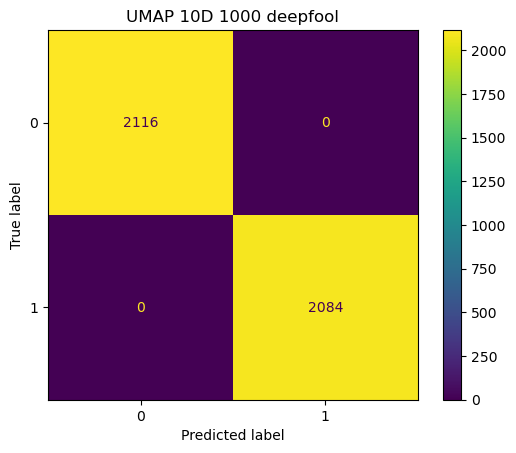

In [290]:
# plot the confusion matrix
cmDT = ConfusionMatrixDisplay.from_estimator(clfDT, X_test,y_test,display_labels=['0','1'])
cmDT.ax_.set_title("UMAP 10D 1000 deepfool")
#cmDT.plot()
plt.show()

In [292]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix

# Collect predictions of different models into a list
y_DT = clfDT.predict(X_test)
l_pred = [y_DT]

# List of model names
modelnames = ["Decision Tree"]

for y_pred, model in zip(l_pred, modelnames):
    # Calculate performance metrics
    TPR = recall_score(y_test, y_pred)  # Sensitivity/Recall
    PPV = precision_score(y_test, y_pred)  # Precision
    ACC = accuracy_score(y_test, y_pred)  # Accuracy
    F1 = f1_score(y_test, y_pred)  # F1-score
    
    # Compute Confusion Matrix: [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calculate FPR and FNR
    FPR = fp / (fp + tn) if (fp + tn) != 0 else 0
    FNR = fn / (fn + tp) if (fn + tp) != 0 else 0
    TNR = tn / (tn + fp) if (tn + fp) != 0 else 0

    # Print results
    print("{}:\tTPR = {:.6f},\tPPV = {:.2f},\tACC = {:.6f},\tF1-score = {:.6f},\tFPR = {:.6f},\tFNR = {:.6f},\tTNR = {:.6f}"
          .format(model, TPR, PPV, ACC, F1, FPR, FNR,TNR))

Decision Tree:	TPR = 1.000000,	PPV = 1.00,	ACC = 1.000000,	F1-score = 1.000000,	FPR = 0.000000,	FNR = 0.000000,	TNR = 1.000000


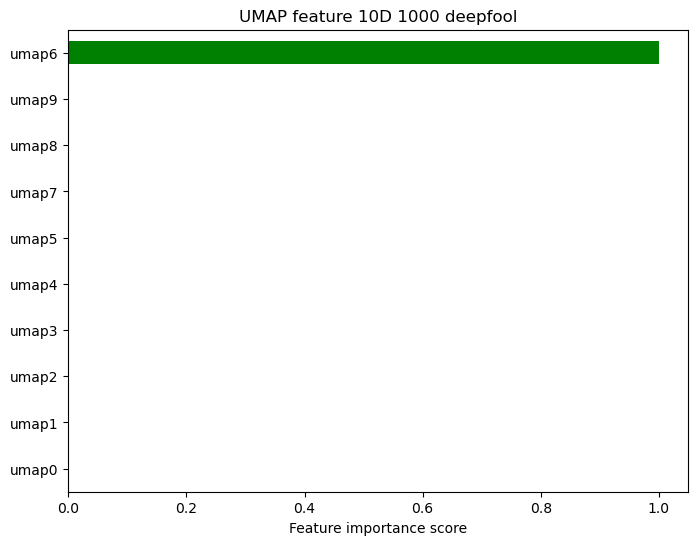

In [294]:
# feature importance
fi_dt_clfDT = pd.Series(clfDT.feature_importances_, index=X.columns)
fi_dt_clfDT = fi_dt_clfDT.sort_values(ascending=True)
plt.figure(figsize=(8, 6))
fi_dt_clfDT.plot(kind='barh', title="UMAP feature 10D 1000 deepfool", color='green')
plt.xlabel("Feature importance score")
#plt.savefig("XAI UMAP 10D 2000 deepfool.png", dpi=300, bbox_inches="tight")
plt.show()

In [296]:
rulesDT_opt = get_rules(clfDT, list(clfDT.feature_names_in_), [0,1], output_label)
for rule in rulesDT_opt:
    covering, error = computeRuleMetrics(rule,X_train,y_train)
    print(rule+f", covering = {covering}, error = {error}")

RULE 1: IF umap6 <= 4.433 THEN attack = 1, covering = 1.0, error = 0.0
RULE 2: IF umap6 > 4.433 THEN attack = 0, covering = 1.0, error = 0.0


In [298]:
# Initialize an empty list to store rule data
rule_data = []

# Loop over the rules, compute covering and error, and store the results in the list
for i, rule in enumerate(rulesDT_opt, 1):
    covering, error = computeRuleMetrics(rule, X_train, y_train)
    rule_data.append([rule, covering, error])

# Create a DataFrame with the rule data
df = pd.DataFrame(rule_data, columns=["Rule", "Covering", "Error"])

# Save the CSV file
#df.to_csv('umap_10D_fgsm0.01_rules.csv', index=False)

## **K-Fold cross validation with DeepFool UMAP data**

Fold 1
Confusion Matrix:
 [[691   0]
 [  0 709]]
Performance for Fold 1:
Accuracy: 1.0000, TPR: 1.0000, TNR: 1.0000, PPV: 1.0000, F1-Score: 1.0000, FPR: 0.0000, FNR: 0.0000


Rule Metrics for Fold 1:


Feature Importance for Fold 1:
umap6    1.0
umap0    0.0
umap1    0.0
umap2    0.0
umap3    0.0
umap4    0.0
umap5    0.0
umap7    0.0
umap8    0.0
umap9    0.0
dtype: float64




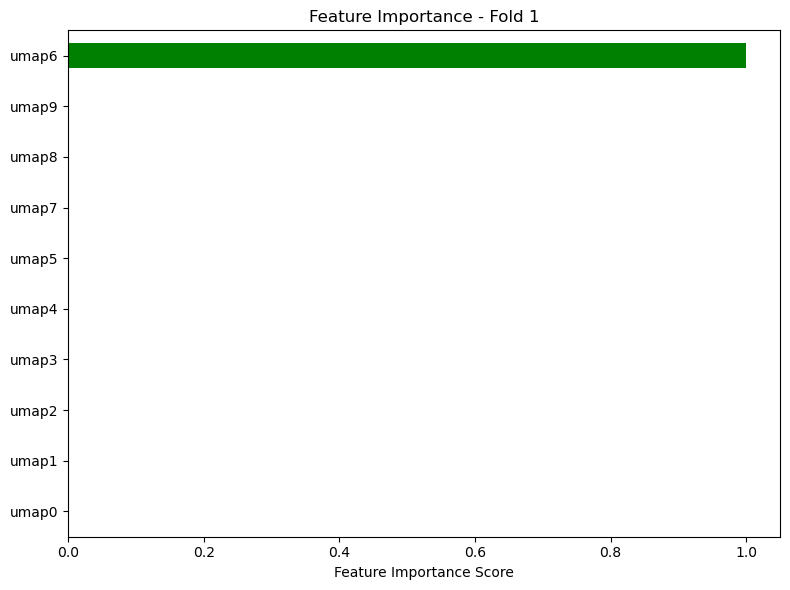

Fold 1 completed. Results saved.
Fold 2
Confusion Matrix:
 [[724   0]
 [  0 676]]
Performance for Fold 2:
Accuracy: 1.0000, TPR: 1.0000, TNR: 1.0000, PPV: 1.0000, F1-Score: 1.0000, FPR: 0.0000, FNR: 0.0000


Rule Metrics for Fold 2:


Feature Importance for Fold 2:
umap6    1.0
umap0    0.0
umap1    0.0
umap2    0.0
umap3    0.0
umap4    0.0
umap5    0.0
umap7    0.0
umap8    0.0
umap9    0.0
dtype: float64




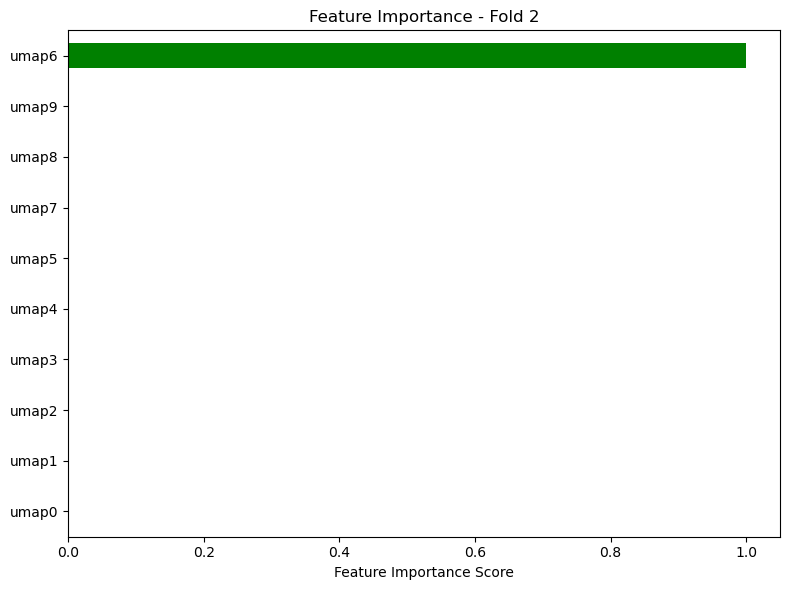

Fold 2 completed. Results saved.
Fold 3
Confusion Matrix:
 [[701   0]
 [  0 699]]
Performance for Fold 3:
Accuracy: 1.0000, TPR: 1.0000, TNR: 1.0000, PPV: 1.0000, F1-Score: 1.0000, FPR: 0.0000, FNR: 0.0000


Rule Metrics for Fold 3:


Feature Importance for Fold 3:
umap6    1.0
umap0    0.0
umap1    0.0
umap2    0.0
umap3    0.0
umap4    0.0
umap5    0.0
umap7    0.0
umap8    0.0
umap9    0.0
dtype: float64




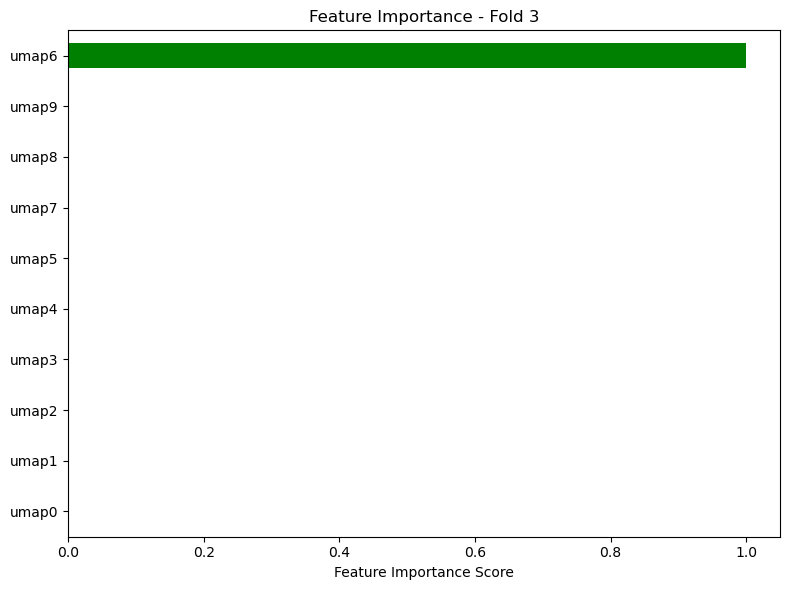

Fold 3 completed. Results saved.
Fold 4
Confusion Matrix:
 [[691   0]
 [  0 709]]
Performance for Fold 4:
Accuracy: 1.0000, TPR: 1.0000, TNR: 1.0000, PPV: 1.0000, F1-Score: 1.0000, FPR: 0.0000, FNR: 0.0000


Rule Metrics for Fold 4:


Feature Importance for Fold 4:
umap6    1.0
umap0    0.0
umap1    0.0
umap2    0.0
umap3    0.0
umap4    0.0
umap5    0.0
umap7    0.0
umap8    0.0
umap9    0.0
dtype: float64




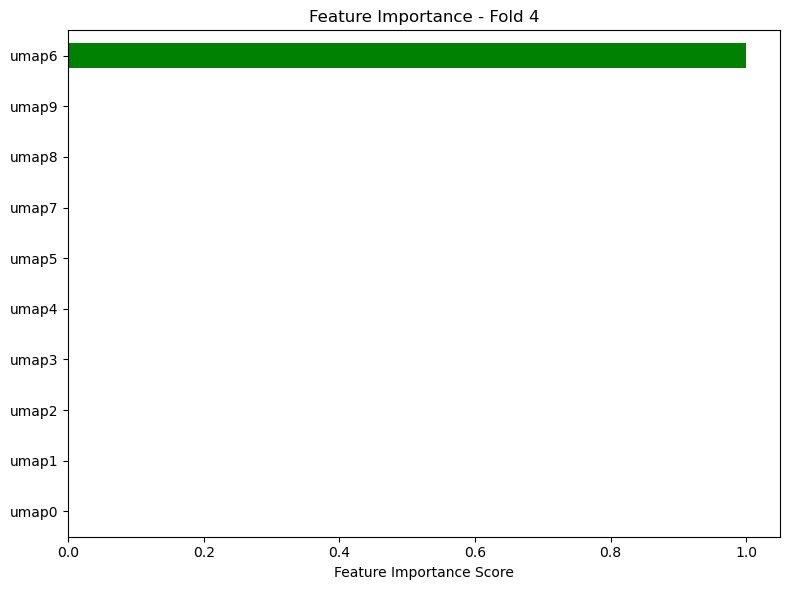

Fold 4 completed. Results saved.
Fold 5
Confusion Matrix:
 [[722   0]
 [  0 678]]
Performance for Fold 5:
Accuracy: 1.0000, TPR: 1.0000, TNR: 1.0000, PPV: 1.0000, F1-Score: 1.0000, FPR: 0.0000, FNR: 0.0000


Rule Metrics for Fold 5:


Feature Importance for Fold 5:
umap6    1.0
umap0    0.0
umap1    0.0
umap2    0.0
umap3    0.0
umap4    0.0
umap5    0.0
umap7    0.0
umap8    0.0
umap9    0.0
dtype: float64




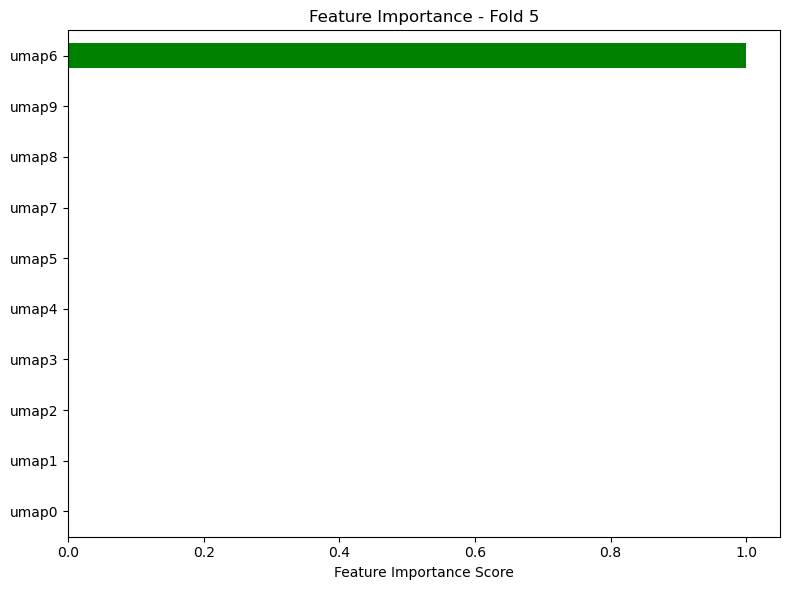

Fold 5 completed. Results saved.
Fold 6
Confusion Matrix:
 [[688   0]
 [  0 712]]
Performance for Fold 6:
Accuracy: 1.0000, TPR: 1.0000, TNR: 1.0000, PPV: 1.0000, F1-Score: 1.0000, FPR: 0.0000, FNR: 0.0000


Rule Metrics for Fold 6:


Feature Importance for Fold 6:
umap6    1.0
umap0    0.0
umap1    0.0
umap2    0.0
umap3    0.0
umap4    0.0
umap5    0.0
umap7    0.0
umap8    0.0
umap9    0.0
dtype: float64




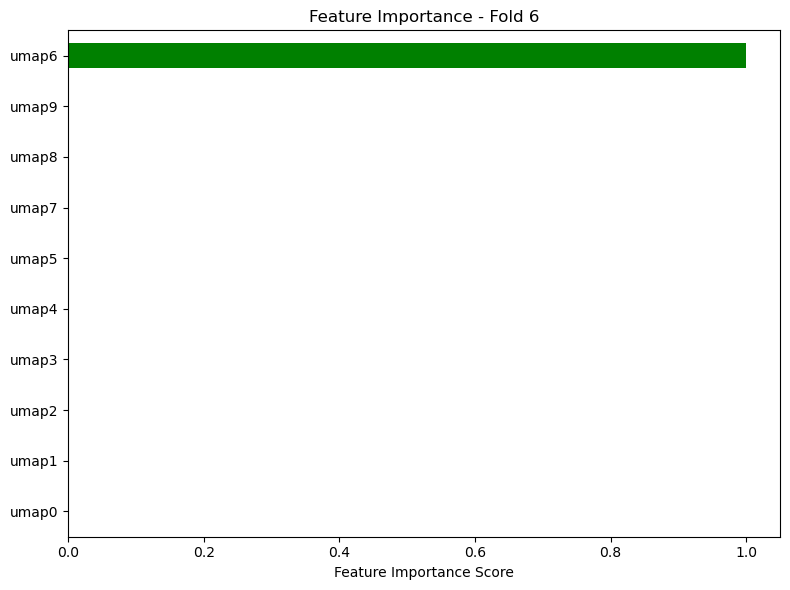

Fold 6 completed. Results saved.
Fold 7
Confusion Matrix:
 [[738   0]
 [  0 662]]
Performance for Fold 7:
Accuracy: 1.0000, TPR: 1.0000, TNR: 1.0000, PPV: 1.0000, F1-Score: 1.0000, FPR: 0.0000, FNR: 0.0000


Rule Metrics for Fold 7:


Feature Importance for Fold 7:
umap6    1.0
umap0    0.0
umap1    0.0
umap2    0.0
umap3    0.0
umap4    0.0
umap5    0.0
umap7    0.0
umap8    0.0
umap9    0.0
dtype: float64




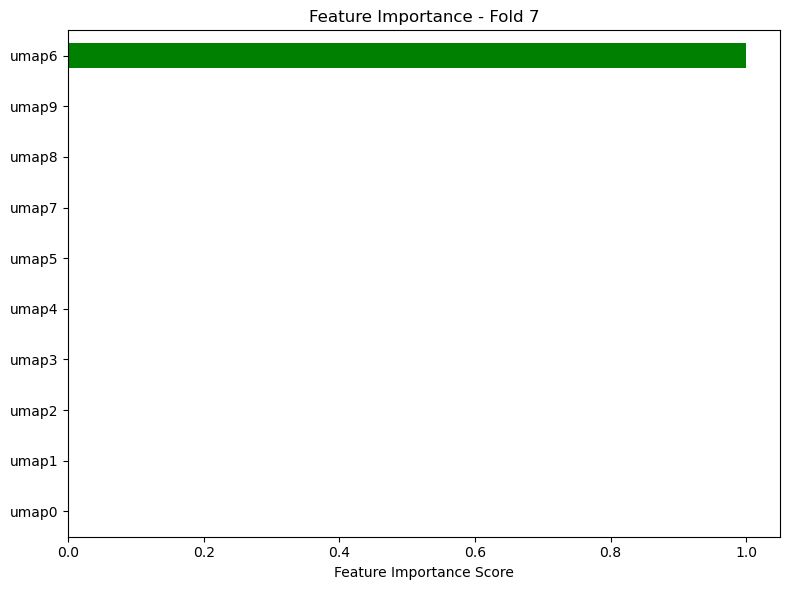

Fold 7 completed. Results saved.
Fold 8
Confusion Matrix:
 [[674   0]
 [  0 726]]
Performance for Fold 8:
Accuracy: 1.0000, TPR: 1.0000, TNR: 1.0000, PPV: 1.0000, F1-Score: 1.0000, FPR: 0.0000, FNR: 0.0000


Rule Metrics for Fold 8:


Feature Importance for Fold 8:
umap6    1.0
umap0    0.0
umap1    0.0
umap2    0.0
umap3    0.0
umap4    0.0
umap5    0.0
umap7    0.0
umap8    0.0
umap9    0.0
dtype: float64




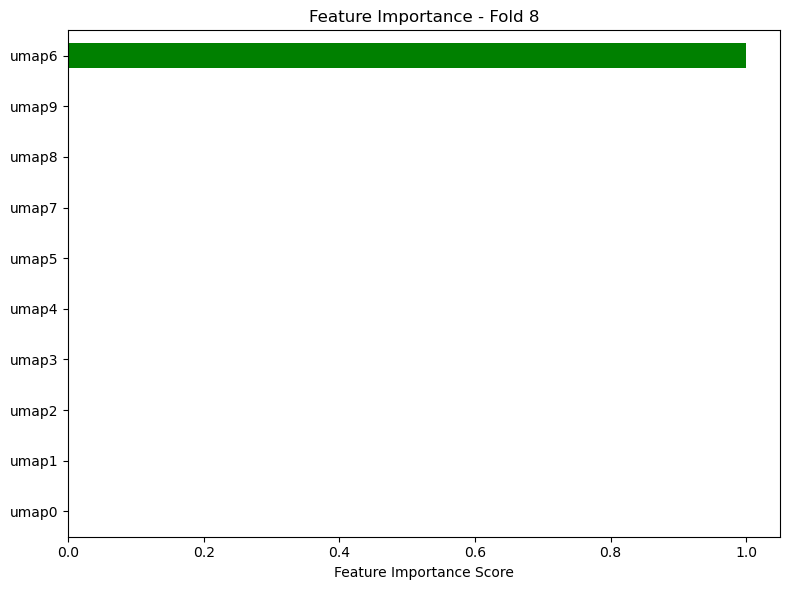

Fold 8 completed. Results saved.
Fold 9
Confusion Matrix:
 [[665   0]
 [  0 735]]
Performance for Fold 9:
Accuracy: 1.0000, TPR: 1.0000, TNR: 1.0000, PPV: 1.0000, F1-Score: 1.0000, FPR: 0.0000, FNR: 0.0000


Rule Metrics for Fold 9:


Feature Importance for Fold 9:
umap6    1.0
umap0    0.0
umap1    0.0
umap2    0.0
umap3    0.0
umap4    0.0
umap5    0.0
umap7    0.0
umap8    0.0
umap9    0.0
dtype: float64




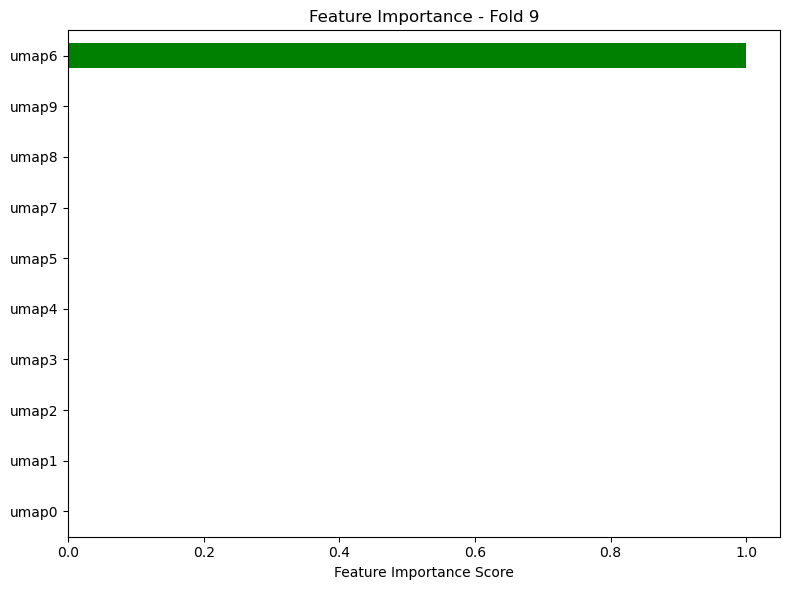

Fold 9 completed. Results saved.
Fold 10
Confusion Matrix:
 [[706   0]
 [  0 694]]
Performance for Fold 10:
Accuracy: 1.0000, TPR: 1.0000, TNR: 1.0000, PPV: 1.0000, F1-Score: 1.0000, FPR: 0.0000, FNR: 0.0000


Rule Metrics for Fold 10:


Feature Importance for Fold 10:
umap6    1.0
umap0    0.0
umap1    0.0
umap2    0.0
umap3    0.0
umap4    0.0
umap5    0.0
umap7    0.0
umap8    0.0
umap9    0.0
dtype: float64




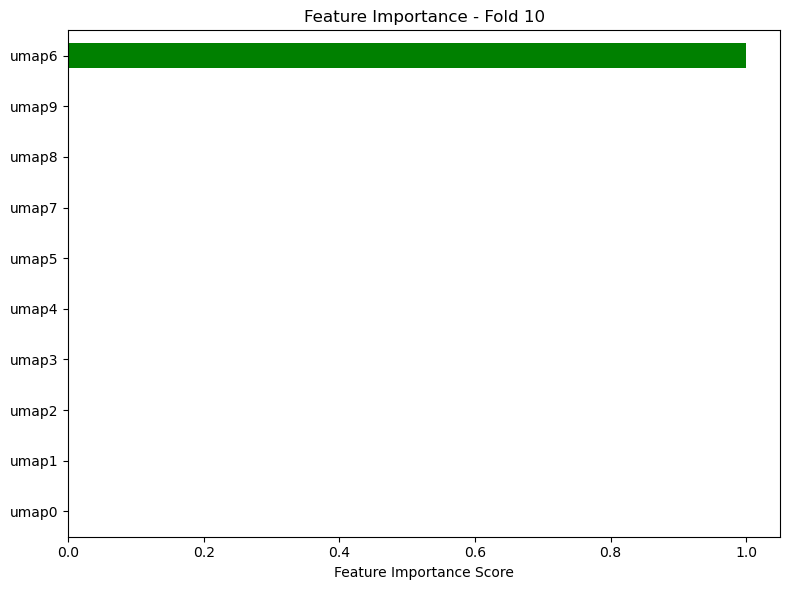

Fold 10 completed. Results saved.

AVERAGE CROSS-VALIDATION SCORES:
Accuracy: 1.0000
TPR: 1.0000
TNR: 1.0000
PPV: 1.0000
F1: 1.0000
FPR: 0.0000
FNR: 0.0000


In [301]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Metrics storage
metrics_all_folds = {
    "Accuracy": [], "TPR": [], "TNR": [], "PPV": [], "F1": [], "FPR": [], "FNR": []
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=2, max_depth=3, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    print("Confusion Matrix:\n", cm)
    tn, fp, fn, tp = cm.ravel()
    
    
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0
    ppv = precision
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

    # Save metrics for average computation
    metrics_all_folds["Accuracy"].append(accuracy)
    metrics_all_folds["TPR"].append(tpr)
    metrics_all_folds["TNR"].append(tnr)
    metrics_all_folds["PPV"].append(ppv)
    metrics_all_folds["F1"].append(f1)
    metrics_all_folds["FPR"].append(fpr)
    metrics_all_folds["FNR"].append(fnr)

    print(f"Performance for Fold {fold + 1}:")
    print(f"Accuracy: {accuracy:.4f}, TPR: {tpr:.4f}, TNR: {tnr:.4f}, "
          f"PPV: {ppv:.4f}, F1-Score: {f1:.4f}, FPR: {fpr:.4f}, FNR: {fnr:.4f}")
    print("\n")

    rulesDT_opt = get_rules(clf, list(clf.feature_names_in_), [0, 1], output_label)

    print(f"Rule Metrics for Fold {fold + 1}:")
    rule_data = []
    for rule in rulesDT_opt:
        covering, error = computeRuleMetrics(rule, X_train, y_train)
        rule_data.append({"Fold": fold + 1, "Rule": rule, "Covering": covering, "Error": error})
    print("\n")

    rule_df = pd.DataFrame(rule_data)
    #rule_df.to_csv(f"rule_metrics_fold_{fold + 1}.csv", index=False)

    feature_importance = clf.feature_importances_
    print(f"Feature Importance for Fold {fold + 1}:")
    print(pd.Series(feature_importance, index=X.columns).sort_values(ascending=False))
    print("\n")

    fi_series = pd.Series(feature_importance, index=X.columns).sort_values(ascending=True)
    plt.figure(figsize=(8, 6))
    fi_series.plot(kind='barh', title=f"Feature Importance - Fold {fold + 1}", color='green')
    plt.xlabel("Feature Importance Score")
    plt.tight_layout()
    #plt.savefig(f"Feature_Importance_Fold_{fold + 1}.png", dpi=300)
    plt.show()

    print(f"Fold {fold + 1} completed. Results saved.")
    print("=" * 50)

# ======= AVERAGE SCORES ======= #
print("\nAVERAGE CROSS-VALIDATION SCORES:")
for metric, values in metrics_all_folds.items():
    avg_score = sum(values) / len(values)
    print(f"{metric}: {avg_score:.4f}")